# The Oerlemans & Nick frontal ablation parameterization in OGGM

We implement the very simple frontal ablation parameterization of [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) in OGGM's flowline model:

$$F_{calving} = k d H_f w$$

With $H_f$, $d$ and $w$ the ice thickness, the water depth and the glacier width at the calving front, $F_{calving}$ the calving flux in units m$^3$ yr$^{-1}$ and $k$ a scaling parameter that needs to be calibrated (units: yr$^{-1}$). Another way to see at this equation is to note that the frontal calving rate $\frac{F_{Calving}}{H_f w}$ (m yr$^{-1}$) is simply the water depth scaled by the $k$ parameter.

The implementation in OGGM's flowline model was relatively straightforward but required some tricks. You can have a look at the code [here](https://github.com/OGGM/oggm/blob/b5934589466bc5245303ce762572f2df8cf92369/oggm/core/flowline.py#L1322-L1379), but in short:
- the terminus thickness $H_f$ is defined as the last grid point on the calving flowline with its surface elevation **above the water level**. That is, if small chunks of ice after that are below water, their thickness is not used for the calving equation.
- the calving flux computed with the equation above is added to a "bucket". This bucket can be understood as "ice that has calved but has not yet been removed from the flowline geometry". We remove this bucket from the total flowline volume when computing model output, though.
- when there is ice below water (e.g. due to ice deformation at the front) and the bucket is large enough, remove it and subtract its volume from the bucket.
- if, after that, the bucket is larger than the total volume of the last flowline grid point above water (the calving front), remove the calving front (calve it) and subtract its volume from the bucket.

To avoid numerical difficulties, we introduce a "flux limiter" at the glacier terminus. The slope between the last grid point above water (the calving front) and the next grid point (often: the sea bed) is cropped to a maximum threshold (per default: the difference between the calving front altitude and the water level) in order to limit ice deformation. See the example below for details.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import time, os

from oggm.core.massbalance import ScalarMassBalance
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.tests.funcs import bu_tidewater_bed
from oggm.core.flowline import FluxBasedModel

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False

## 1. Idealized experiments 

We use the idealized bed profile from [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) and [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160). This profile has a deepening followed by a bump, allowing to study quite interesting water-depth – calving-rate feedbacks:

In [ ]:
bu_fl = bu_tidewater_bed()[0]

xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(xc, bu_fl.bed_h, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

### 1.1 Equilibrium states

We create a simple experiment where the surface mass-balance is zero in the entire domain. Ice enters via a flux gate on the left (unit: m$^{3}$ s$^{-1}$). We can vary the amount of ice entering the domain via the flux gate. We let the glacier grow until equilibrium with three different flux values:

In [ ]:
mb_model = ScalarMassBalance()

to_plot = None
keys = []
for flux_gate in [0.06, 0.10, 0.16]:
    model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                           is_tidewater=True, 
                           flux_gate=flux_gate,  # default is 0
                           calving_k=0.2,  # default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium 
    _, ds = model.run_until_and_store(6000)
    df_diag = model.get_diagnostics()
    
    if to_plot is None:
        to_plot = df_diag
    
    key = 'Flux gate={:.02f}. Calving rate: {:.0f} m yr-1'.format(flux_gate, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
to_plot.index = xc

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

The larger the incoming ice flux, the bigger and longer the glacier. If the flux is large enough, the glacier will grow past the deepening and the bump, until the water depth and the calving rate become large enough to compensate for the total ice entering the domain.

### 1.2 Flux limiter 

The frontal "free board" (the height of the ice above water at the terminus) is quite high in the plot above. This is because we use a "flux limiter", effectively reducing the shear stress at the steep glacier front and avoiding high velocities, simplifying the numerics. This limiter is of course arbitrary and non-physical, but we still recommend to switch it on for your runs. Here we show the differences between two runs (with and without flux limiter):

In [ ]:
to_plot = None
keys = []
for limiter in [True, False]:
    model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                           is_tidewater=True, 
                           calving_use_limiter=limiter,  # default is True
                           flux_gate=0.06,  # default is 0
                           calving_k=0.2,  # default is 2.4
                           do_kcalving=True
                          )
    # long enough to reach approx. equilibrium 
    _, ds = model.run_until_and_store(7000)
    df_diag = model.get_diagnostics()
    
    if to_plot is None:
        to_plot = df_diag
    
    key = 'Flux limiter={}. Calving rate: {:.0f} m yr-1'.format(limiter, model.calving_rate_myr)
    to_plot[key] = df_diag['surface_h']
    keys.append(key)
    
    # Plot of volume
    (ds.volume_m3 * 1e-9).plot(label=key);
plt.legend(); plt.ylabel('Volume [km$^{3}$]');
to_plot.index = xc

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
to_plot[keys].plot(ax=ax);
to_plot.bed_h.plot(ax=ax, color='k')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.ylim(-350, 1000); plt.ylabel('Altitude [m]'); plt.xlabel('Distance along flowline [km]');

For the rest of this notebook, we will keep the flux limiter **on**. It is also switched on per default in OGGM.

In [ ]:
# see
cfg.PARAMS['calving_use_limiter']

### 1.3 Water-depth – calving-rate feedbacks

Let's have some fun! We apply a periodic forcing to our glacier and study the advance and retreat of our glacier (the simulation below can take a couple minutes to run).

In [ ]:
years = np.arange(6001)
flux = 0.4 + 0.4 * np.sin(2 * np.pi * years / 5000)
def flux_gate(year):
    return flux[int(year)]

In [ ]:
model = FluxBasedModel(bu_tidewater_bed(), mb_model=mb_model,
                       is_tidewater=True, 
                       glen_a=cfg.PARAMS['glen_a']*3, # make the glacier flow faster
                       flux_gate=flux_gate,  # default is 0
                       calving_k=1,  # default is 2.4
                       do_kcalving=True
                      )
t0 = time.time()
_, ds = model.run_until_and_store(len(flux)-1)
print('Done! Time needed: {}s'.format(int(time.time()-t0)))

In [ ]:
# Prepare the data for plotting
df = (ds.volume_m3 * 1e-9).to_dataframe(name='Volume [km$^3$]')[['Volume [km$^3$]']]
df['Length [m]'] = (ds['length_m'] / 1000).to_series()
df['Calving rate [m y$^{-1}$]'] = ds['calving_rate_myr'].to_series()
df['Forcing'] = flux

# Thresholds
deep_val = 27
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index < 5000)]
deep_t0, deep_t1 = dfs.index[0], dfs.index[-1]
dfs = df.loc[(df['Length [m]'] >= deep_val) & (df.index > 5000)]
deep_t2 = dfs.index[0]

bump_val = 37.5
dfs = df.loc[(df['Length [m]'] >= bump_val) & (df.index < 5000)]
bump_t0, bump_t1 = dfs.index[0], dfs.index[-1]

In [ ]:
# The plot
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
ts = df['Forcing']
ts.plot(ax=ax1, color='C0');
ax1.set_ylabel(ts.name)
ts = df['Length [m]']
ts.plot(ax=ax2, color='C1');
ax2.hlines(deep_val, deep_t0, deep_t1, color='black', linestyles=':')
ax2.hlines(deep_val, deep_t2, 6000, color='black', linestyles=':')
ax2.hlines(bump_val, bump_t0, bump_t1, color='grey', linestyles='--')
ax2.annotate('Deepening', (deep_t0, deep_val-5))
ax2.annotate('Bump', (bump_t0, bump_val-5))
ax2.set_ylabel(ts.name)
# The calving rate is a bit noisy because of the bucket trick - we smooth
ts = df['Calving rate [m y$^{-1}$]'].rolling(11, center=True).max()
ts.plot(ax=ax3, color='C3')
ax3.vlines([deep_t0, deep_t1, deep_t2], ts.min(), ts.max(), color='black', linestyles=':')
ax3.vlines([bump_t0, bump_t1], ts.min(), ts.max(), color='grey', linestyles='--');
ax3.set_ylabel(ts.name); ax3.set_xlabel('Years');

Our simple model reproduces the results of [Oerlemans & Nick (2005)](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F) and [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160) qualitatively (with the models and model parameters being different, an exact comparison is difficult). For example, here is Fig. 8 from [Bassis & Ultee (2019)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JF005160):

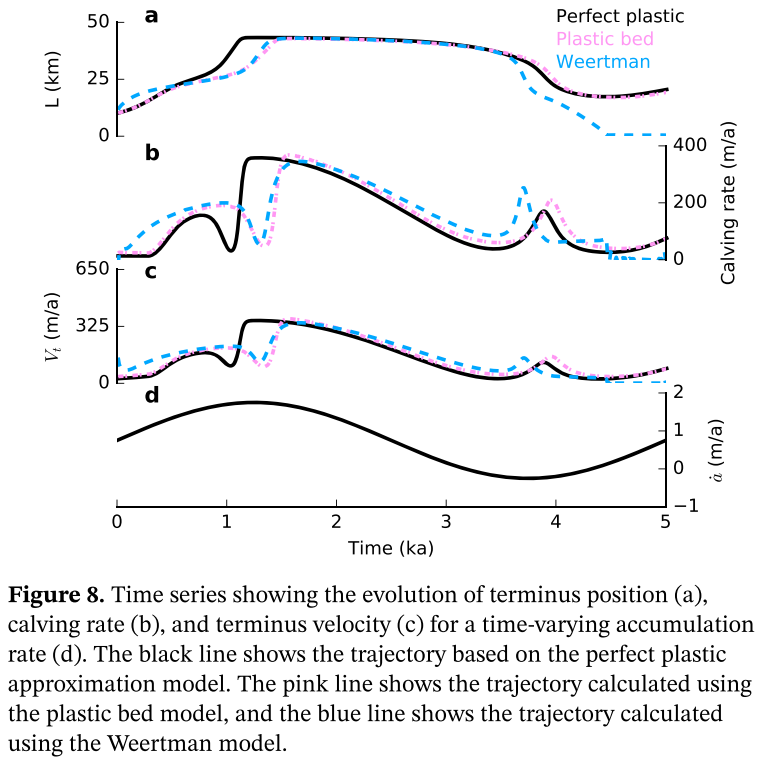

## 2. Application to a real glacier 

### 2.1 Pick a glacier

We take the famous Columbia glacier for the examples below, but you can try any other glacier (with very variable results).

In [ ]:
rgi_id = 'RGI60-01.10689'
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-Calving', reset=True)
cp_dir = os.path.join(cfg.PATHS['working_dir'], 'calving')

# Download from the "OGGM shop" 
gdir_woc = workflow.init_glacier_directories([rgi_id], from_prepro_level=3, prepro_border=80)[0]
tasks.init_present_time_glacier(gdir_woc)

In [ ]:
graphics.plot_googlemap(gdir_woc, figsize=(6,6));

### 2.2 Inversion with calving 

We apply the method described in [Recinos et al., (2019)](https://www.the-cryosphere.net/13/2657/2019/tc-13-2657-2019.html), and applied with examples in [this notebook](inversion_with_frontal_ablation.ipynb). Let's pick some model parameters and apply the inversion.

In [ ]:
# Calving params - default used to be 2.4, we changed it to 0.6
cfg.PARAMS['inversion_calving_k'] = 0.6
cfg.PARAMS['calving_k'] = 0.6

# These are switched off per default
cfg.PARAMS['use_kcalving_for_inversion'] = True
cfg.PARAMS['use_kcalving_for_run'] = True 

# Reference data for the recalibration of the mass-balance
ref_tstars_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/oggm_v1.4/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=ref_tstars_url)

# Back to regular OGGM defaults
cfg.PARAMS['cfl_number'] = 0.02

# Make a copy of our glacier directory where we will make the experiments
utils.mkdir(cp_dir, reset=True)
gdir_wc = utils.copy_to_basedir(gdir_woc, base_dir=cp_dir, setup='all')
# Find out the calving values
out_calving = tasks.find_inversion_calving(gdir_wc)
# Get ready
tasks.init_present_time_glacier(gdir_wc)
# print output
out_calving

It must be noted that the glacier terminus elevation (244 m a.s.l) is very high, and likely an artifact of the DEM data we used. Since [April 2020](https://github.com/OGGM/oggm/pull/996) we mitigate these uncertainties but they aren't fully tested. Regardless, the effect of imposing calving to the ice thickness inversion algorithm will have two main effects: 
- increasing the ice thickness of the glacier tongue, mostly at the terminus
- reducing the temperature sensitivity of the mass-balance model ($\mu^*$), because melt is reduced by allowing a calving flux at the terminus

These are the results for the Columbia glacier and k=1:

In [ ]:
fl = gdir_woc.read_pickle('model_flowlines')[-1]
xc = fl.dis_on_line * fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 5))
var = ['Surface yr 0', 'Bed (without calving)', 'Bed (with calving)']
plt.plot(xc, fl.surface_h, '-', color='C1', label='Surface')
plt.plot(xc, fl.bed_h, ':', color='k', label='Glacier bed (without calving)')
plt.plot(xc, gdir_wc.read_pickle('model_flowlines')[-1].bed_h, '--', color='k', label='Glacier bed (with calving)')
plt.hlines(0, 0, xc[-1], color='grey', linestyle=':', label='Sea level')
plt.hlines(out_calving['calving_water_level'], 0, xc[-1], color='C0', linestyle=':', label='Calving water level'), plt.legend();

The slope of the seafloor after the terminus is arbitrarily set to a constant:

In [ ]:
cfg.PARAMS['calving_front_slope']

### 2.3 Simulation with and without calving and different beds

Here, we simulate the evolution of the glacier under recent climate conditions (i.e. a "committed mass-loss run"), once for each bed shape:

In [ ]:
model_woc = tasks.run_constant_climate(gdir_woc, y0=2000, nyears=100, water_level=out_calving['calving_water_level'])
model_wc = tasks.run_constant_climate(gdir_wc, y0=2000, nyears=100)

In [ ]:
df_diag = model_woc.get_diagnostics()
df_tmp = model_wc.get_diagnostics()
df_diag['Bed (with calving)'] = df_tmp['bed_h']
df_diag['Bed (without calving)'] = df_diag['bed_h']
df_diag['Surface yr 0'] = gdir_woc.read_pickle('model_flowlines')[-1].surface_h
df_diag['Surface yr 100 (with calving)'] = df_tmp['surface_h']
df_diag['Surface yr 100 (without calving)'] = df_diag['surface_h']
df_diag.index = df_tmp.index.values / 1000
df_diag.index.name = 'Distance along flowline [km]'
df_diag = df_diag.loc[df_diag['Surface yr 0'] > df_diag['Bed (without calving)']]

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 5))
var = ['Surface yr 100 (with calving)', 'Bed (with calving)', 'Surface yr 100 (without calving)', 'Bed (without calving)']
df_diag[var].plot(ax=ax, style=['-', '--', '-', ':'], color=['C2', 'k', 'C3', 'k']);
plt.hlines(out_calving['calving_water_level'], 0, df_diag.index[-1], color='C0', linestyle=':');

There is a large difference between the two simulations. Let's have a look at glacier volume evolution and calving rate in that period: 

In [ ]:
with xr.open_dataset(gdir_wc.get_filepath('model_diagnostics')) as ds_wc:
    with xr.open_dataset(gdir_woc.get_filepath('model_diagnostics')) as ds_woc:
        ds_wc = ds_wc.isel(time=slice(1, -1))
        ds_woc = ds_woc.isel(time=slice(1, -1))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        (ds_wc.volume_m3 * 1e-9).plot(ax=ax1, label='With calving');
        (ds_woc.volume_m3 * 1e-9).plot(ax=ax1, label='Without calving');
        ax1.legend()
        ax1.set_ylabel('Volume [km$^3$]'); ax1.set_xlabel('Simulation time (yrs)');
        
        ds_wc.calving_rate_myr.plot(ax=ax2, label='With calving');
        ds_woc.calving_rate_myr.plot(ax=ax2, label='Without calving');
        ax2.set_ylabel('Calving rate [m yr$^{-1}$]'); ax2.set_xlabel('Simulation time (yrs)');

While calving during the simulation time definitely plays a role, the main differences between the two simulations are the starting volume of the glaciers, and the effect of the smaller temperature sensitivity, leading to less melt at the end of the century.

### 2.4 Simulation with and without calving and same glacier bed

To isolate the effect of calving only on the dynamical simulation, we run a third simulation where we use the same boundary conditions and temperature sensitivity as in the calving case, but with calving switched off:  

In [ ]:
cfg.PARAMS['use_kcalving_for_run'] = False
cfg.PARAMS['error_when_glacier_reaches_boundaries'] = False # we need this because glacier grows
model_woc_2 = tasks.run_constant_climate(gdir_woc, y0=2000, nyears=100, output_filesuffix='_woc_2')
cfg.PARAMS['use_kcalving_for_run'] = True

In [ ]:
with xr.open_dataset(gdir_woc.get_filepath('model_diagnostics')) as ds_wc:
    with xr.open_dataset(gdir_woc.get_filepath('model_diagnostics', filesuffix='_woc_2')) as ds_woc:
        ds_wc = ds_wc.isel(time=slice(1, -1))
        ds_woc = ds_woc.isel(time=slice(1, -1))
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        (ds_wc.volume_m3 * 1e-9).plot(ax=ax1, label='With calving');
        (ds_woc.volume_m3 * 1e-9).plot(ax=ax1, label='Without calving');
        ax1.legend()
        ax1.set_ylabel('Volume [km$^3$]'); ax1.set_xlabel('Simulation time (yrs)');
        
        ds_wc.calving_rate_myr.plot(ax=ax2, label='With calving');
        ds_woc.calving_rate_myr.plot(ax=ax2, label='Without calving');
        ax2.set_ylabel('Calving rate [m yr$^{-1}$]'); ax2.set_xlabel('Simulation time (yrs)');

In this case, the starting volume is the same. The main impact of calving is to increase glacier retreat rates during most part of the century. 

## Final remarks 

- this frontal parameterization is very basic. It doesn't include indirect dynamical feedbacks such as sliding or slipping or fracturing, etc.
- it's first order effect on the inversion is likely to have the largest influence on the simulations, but the calving effect on ice dynamics will be significant in some cases as well.
- there is still a lot of uncertainty about the boundary conditions (elevation of the calving front, its width, etc.) and this will affect calving and the temperature sensitivity a lot

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)